## Integrating Ocean QUBO implementation with Pennylane's QAOA implementation

In [1]:
import dimod
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_qml_hamiltionian(bqm):
    var_to_z_number = {}
    for i, var in enumerate(bqm.linear):
        var_to_z_number[var] = i
        
    coeffs = []
    obs = []
    
    for var in bqm.iter_linear():
        z_number = var_to_z_number[var[0]]
        obs.append(qml.PauliZ(z_number))
        coeffs.append(float(var[1]))
    for var in bqm.iter_quadratic():
        z_number1 = var_to_z_number[var[0]]
        z_number2 = var_to_z_number[var[1]]
        obs.append(qml.PauliZ(z_number1) @ qml.PauliZ(z_number2))
        coeffs.append(float(var[2]))
    
    obs.append(qml.Identity(0))
    coeffs.append(bqm.offset)
    H = qml.Hamiltonian(coeffs, obs)
    return (H, qaoa.x_mixer(var_to_z_number.values()))

In [3]:
vartype = dimod.BINARY
linear = {'x': 1, 'y': 1}
quadratic = {('x','y') : 2}
offset = 1.0

bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)

cost, mix = get_qml_hamiltionian(bqm)
print(cost)
print(mix)

  (1.0) [Z0]
+ (1.0) [Z1]
+ (1.0) [I0]
+ (2.0) [Z1 Z0]
  (1) [X0]
+ (1) [X1]


In [4]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost)
    qaoa.mixer_layer(alpha, mix)

In [5]:
wires = range(len(bqm.linear))
depth = 1
dev = qml.device("default.qubit", wires=wires)

def qaoa_circuit(params):
    qml.broadcast(qml.Hadamard, wires, 'single')
    qml.layer(qaoa_layer, depth, params[0], params[1])
    

@qml.qnode(dev)
def cost_function(params):
    qaoa_circuit(params)
    return qml.expval(cost)

In [6]:
optimizer = qml.GradientDescentOptimizer()
params = np.array([[0.5], [0.5]], requires_grad=True)

for i in range(70):
    params = optimizer.step(cost_function, params)

print("Optimal parameters:", params)

Optimal parameters: [[0.78539816]
 [0.26187658]]


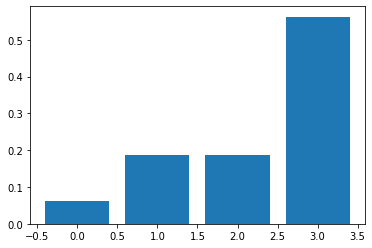

In [7]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    qaoa_circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

plt.bar(range(2 ** len(wires)), probs)
plt.show()